In [1]:
import pickle
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
import contractions
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
import nltk

nlp = spacy.load("en_core_web_trf")
#only_uncleaned_dict=pickle.load(open("only_uncleaned_dict.pickle", "rb"))

#reading df
#submissions_df=pickle.load(open("submissions_df.pickle", "rb"))
#comments_df=pickle.load(open("comments_df.pickle", "rb"))
#submissions_df_2=pickle.load(open("submissions_df_2.pickle", "rb"))
#comments_df_2=pickle.load(open("comments_df_2.pickle", "rb"))




In [15]:
comments_df=pd.concat([comments_df_2,comments_df])
submissions_df=pd.concat([submissions_df, submissions_df_2])

In [16]:


#filtering out comments or submissions with less than three votes
comments_df=comments_df[(comments_df['score']<=0)|(comments_df['score']>=2)]
submissions_df=submissions_df[(submissions_df['score']<=0)|(submissions_df['score']>=2)]
#merging comments and posts 
comments_df=comments_df['body'].append(submissions_df['title']).append(submissions_df['selftext'])
comments_df.name='body'

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

In [17]:

# remove urls up here so they're caught by the filter in next chunk
comments_df=comments_df.dropna().apply(remove_URL)


In [18]:

# save value counts
value_counts = comments_df.value_counts()
# get indices of those with value counts greater than or equal to 2
to_remove = value_counts[value_counts >2].index
# save df as df with all data filtered out
comments_df = comments_df[~comments_df.isin(to_remove)]

#check to make sure looks good
pd.DataFrame(comments_df).value_counts(ascending=False).reset_index()

sample_uncleaned = comments_df.copy()

In [19]:
sample_uncleaned.shape #(667937,) for the original sample_uncleaned


(813869,)

In [226]:
#sample_uncleaned=pickle.load(open("sample_uncleaned.pickle",'rb'))

In [2]:
cryp_list=pickle.load(open("cryp_list_all_format.pickle", "rb"))

flat_list = [item for sublist in cryp_list for item in sublist]


## testing to filter on only a few cryptos to improve speed

In [21]:
sample_uncleaned=comments_df
a = np.array(cryp_list)
b = np.array([0,1,4,5,8,13,14,19])
cryp_list=a[b]


### Saved the resulting dict below as full_only_uncleaned_dict

In [22]:


#empty dict
uncleaned_dict = {}
#saving any mention of each crypto to it's key when no other cryptos mentioned
for index,cryp in enumerate(cryp_list):
    #saves list of all cryptos as a df
    temp=pd.DataFrame(flat_list)
    #then calls all cryptos in df except for the one of interest
    temp=(temp[~temp[0].str.contains('|'.join(cryp_list[index]))][0]).tolist()
    #merge together the list of exclusion cryptos 
    temp=('\\b|\\b'.join(temp))
    #save crypto as key and comments where its mentioned as a series in a df
    uncleaned_dict[cryp[0]] = pd.DataFrame(sample_uncleaned[(sample_uncleaned.str.contains('\\b|\\b'.join(cryp_list[index])))&
    #exclude any comment/post where another crypto was mentioned
                                                            (~sample_uncleaned.str.contains(temp))])

#get rid of empty keys 
uncleaned_dict=uncleaned_dict={k:v for (k,v) in uncleaned_dict.items() if not v.empty}

#SAVING resulting dict
#pickle.dump(uncleaned_dict,open("full_only_uncleaned_dict.pickle", "wb" ))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [23]:
#combine dfs from dict together for processing and save the crypto name
#in the new column, "key"
for crypto, df in uncleaned_dict.items():
    df['key'] = crypto
master_frame = pd.concat(uncleaned_dict, ignore_index=True)



In [44]:
#save processed spaCy NLP data in a new column, 'process'

master_frame['process']=list(nlp.pipe(master_frame['body'])) 

/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [66]:
#Create new colums in the master df for adjectives AND nouns, 
#adjectives, 
#and nouns 
#import stop words
from spacy.lang.en.stop_words import STOP_WORDS
stop = STOP_WORDS
#lemmatize-stemming gave weird results and we have enough data to take the lemmas
master_frame['adjnoun']=[[" ".join(token.lemma_.lower() for token in sentence if
            #don't save stop words
           token.is_stop == False and 
            #save only words
           token.text.isalpha() == True and
            #specifically, nouns
           (token.pos_ == 'NOUN'or 
            #and adjectives
            token.pos_ =='ADJ') and 
            #save only lemmas >= 3 and <=15
           (len(token.lemma_)>=3 and len(token.lemma_)<=15))] 
    for sentence in master_frame['process']]
#adj only
master_frame['adj']=[[" ".join(token.lemma_.lower() for token in sentence if
           token.is_stop == False and 
           token.text.isalpha() == True and
           token.pos_ == 'ADJ' and 
           (len(token.lemma_)>=3 and len(token.lemma_)<=15))] 
    for sentence in master_frame['process']]
#noun only
master_frame['noun']=[[" ".join(token.lemma_.lower() for token in sentence if
           token.is_stop == False and 
           token.text.isalpha() == True and
           token.pos_ == 'NOUN' and 
           (len(token.lemma_)>=3 and len(token.lemma_)<=15))] 
    for sentence in master_frame['process']]

In [ ]:
master_dict=dict(tuple(master_frame.groupby('key')))

In [48]:
#create dicts for the different pos of interest and convert contents into strings
adjnoun_dict=dict(tuple(master_frame.groupby('key')['adjnoun']))
noun_dict=dict(tuple(master_frame.groupby('key')['noun']))
adj_dict=dict(tuple(master_frame.groupby('key')['adj']))

#funcition to join lists in dict key dfs to strings
def try_join(l):
    try:
        return ','.join(map(str, l))
    except TypeError:
        return np.nan
    
#implementing fxn and removing empty values-not sure if this matters 
adjnoun_dict={key: list(filter(None,[try_join(sentence) for sentence in value])) for key, value in adjnoun_dict.items()}
noun_dict={key: list(filter(None,[try_join(sentence) for sentence in value])) for key, value in noun_dict.items()}
adj_dict={key: list(filter(None,[try_join(sentence) for sentence in value])) for key, value in adj_dict.items()}

#saved as pickles ^ eg adjnoun_dict

## importing dicts

In [4]:
adjnoun_dict=pickle.load(open("adjnoun_dict.pickle", "rb"))
adj_dict=pickle.load(open("adj_dict.pickle", "rb"))
noun_dict=pickle.load(open("noun_dict.pickle", "rb"))





In [574]:
#creating list of keys that have more than 1000 comments (in the adjnoun list)

key_list=list()
for key in adjnoun_dict:
    if len(adjnoun_dict[key])>2700:
        key_list.append(key)
        print(key,len(adjnoun_dict[key]))
#key_list.remove('one')



adjnoun_dict_filtered={key: adjnoun_dict[key] for key in key_list}
noun_dict_filtered={key: noun_dict[key] for key in key_list}
adj_dict_filtered={key: adj_dict[key] for key in key_list}




ada 7184
algo 5793
btc 21632
cro 7641
dot 3475
eth 12973
sol 2951


### stopword list here is optional-consider using and modifying if larger amounts of data

In [570]:
from sklearn.feature_extraction import text 

# use these if using stemming instead of lemmatization
#from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
#from nltk.stem import SnowballStemmer
#stemmer = SnowballStemmer("english")

#this should already be loaded in unless reading data from pickle
#import spacy
#nlp = spacy.load("en_core_web_trf")


#text.ENGLISH_STOP_WORDS.union(flat_list)

#read in again since we'll want to use ALL crypto names now
cryp_list=pickle.load(open("cryp_list_all_format.pickle", "rb"))

flat_list = [item for sublist in cryp_list for item in sublist]
#get common words across ALL cryptos-these are probably meaningless for crypto-specific topics
temp=('\\b|\\b'.join(flat_list))
#get top words 
cv = CountVectorizer(min_df=5)
#converting data to series containing all sentences to be use 
full_series=(pd.concat([pd.Series(v) for k,v in adjnoun_dict_filtered.items()]))
#transform 
X_cv_df=cv.fit_transform(full_series).toarray()
#add index, features
X_cv_df=pd.DataFrame(X_cv_df,index=full_series,columns=cv.get_feature_names_out())
#get word counts
word_counts=X_cv_df.sum().sort_values(ascending=False).reset_index()
#list flat list containing list of cryptos and now word counts greater than 1000
#the 1000 limit isn't necessary here since data was filtered more stringently-good to keep in for 
#future use
mask=list(word_counts[(word_counts['index'].str.contains(temp))|(word_counts[0]>1000)]['index'])
#removing nft from the list since it's a crypto name but a topic of interest-the word here
#refers to the topic and not the name of the unpopular crypto

#if stemming in preprocesing, use this after the above

flat_list=[word_tokenize(word) for word in flat_list]
#flat_list=[[stemmer.stem(word) for word in cryp] for cryp in flat_list]
flat_list = [item for sublist in flat_list for item in sublist]

#mask will only return values that we need to remove (eg if another crypto was in the flattened 
# cryp_list but not found in the data we have, it will NOT appear)
flat_list.extend(mask)
# extending list again found in the error "Tokenizing the stop words generated tokens"
flat_list.extend(['ai', 'axs', 'com', 'fetch', 'stacks', 'waves', 'yearn'])
flat_list.remove('nft')

#word_counts.head(25)

#joining to flat list to get lemmas
flat_list=" ".join(flat_list)

doc = nlp(flat_list)

flat_list=[token.lemma_ for token in doc]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


# Getting recommended number of components through turncated SVD explained ratios

In [565]:
#this funciton jsut needs the data and amount of variance wanted to capture

def tsvd_fxn(data, goal_var: float) -> int:
    tfv = TfidfVectorizer(stop_words='english',max_df=.2, min_df=5)#,ngram_range=(1, 3))
    #applying fit_transform on review
    X_tfidf = tfv.fit_transform(data).toarray()
    #converting to df and naming columns and 
    X_tf_df=pd.DataFrame(X_tfidf,index=data,columns=tfv.get_feature_names_out())
    #instantiate nmf
    lsa = TruncatedSVD(n_components=X_tf_df.shape[1]-1)
    #transform the X_vect_df 
    doc_topic = lsa.fit_transform(X_tf_df)
    #ratios explained
    var_ratio=lsa.explained_variance_ratio_
    # Create a function
    def select_n_components(var_ratio, goal_var: float) -> int:
        # Set initial variance explained so far
        total_variance = 0.0

        # Set initial number of features
        n_components = 0

        # For the explained variance of each feature:
        for explained_variance in var_ratio:

            # Add the explained variance to the total
            total_variance += explained_variance

            # Add one to the number of components
            n_components += 1

            # If we reach our goal level of explained variance
            if total_variance >= goal_var:
                # End the loop
                break

        # Return the number of components
        return(n_components)
    return(select_n_components(var_ratio, goal_var))


### Recommended number of components to account for .8 of variance

In [26]:
#adjectives and nouns
{key: tsvd_fxn(value,.8) for key, value in adjnoun_dict.items()}

{'ada': 369,
 'algo': 292,
 'btc': 721,
 'cro': 333,
 'dot': 194,
 'eth': 497,
 'matic': 184,
 'sol': 211}

In [27]:
#nouns only
{key: tsvd_fxn(value,.8) for key, value in noun_dict.items()}

{'ada': 252,
 'algo': 205,
 'btc': 520,
 'cro': 240,
 'dot': 135,
 'eth': 359,
 'matic': 127,
 'sol': 150}

In [28]:
#adjectives only
{key: tsvd_fxn(value,.8) for key, value in adj_dict.items()}

{'ada': 121,
 'algo': 91,
 'btc': 202,
 'cro': 93,
 'dot': 65,
 'eth': 141,
 'matic': 53,
 'sol': 67}

### Looking at stopwords and the number of words appearing most to identify topics

In [571]:
def nmf_fxn(data, dimensions, stop_words, num_words, max_df, min_df):
    dimensionlist = []
    for i in range(dimensions):
        dimensionlist.append("component_"+str(i+1))
    tfv = TfidfVectorizer(stop_words=stop_words,max_df=max_df, min_df=min_df)#,ngram_range=(1, 3))
    #applying fit_transform on review
    X_vect = tfv.fit_transform(data).toarray()
    #converting to df and naming columns and 
    X_vect_df=pd.DataFrame(X_vect,index=data,columns=tfv.get_feature_names_out())
    #instantiate nmf
    nmf = NMF(dimensions, init=None)
    #transform the X_vect_df 
    doc_topic = nmf.fit_transform(X_vect_df)
    # how much each term belongs to the different components
    topic_term=nmf.components_
    topic_term_df=pd.DataFrame(topic_term.round(3), 
             index =  dimensionlist,
             columns = tfv.get_feature_names_out())
    
    
    
    # most common word/phrase for each component
    feat_names = tfv.get_feature_names_out()
    word_dict = {};
    for i in range(dimensions):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = nmf.components_[i].argsort()[:-num_words -1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['topic ' + '{:2d}'.format(i+1)] = words;
    topwords=pd.DataFrame(word_dict);


    
    # df for each term belongs to the different components
    doc_topic_df = pd.DataFrame(doc_topic.round(5),
             index = pd.Series(data),
             columns = dimensionlist)
  
    return(doc_topic_df, topic_term_df, topwords)



In [577]:
#a,b,c=nmf_fxn(adjnoun_dict_filtered['btc'],5,10)
#display(a,b,c)

for key in noun_dict_filtered:
    a,b,c=nmf_fxn(noun_dict_filtered[key],
                  dimensions=5,
                  stop_words=text.ENGLISH_STOP_WORDS.union(flat_list),
                  num_words=10,
                  max_df=.3,
                  min_df=10)
    print(key.upper())
    #doc_topic_df=a
    #topic_term_df=b
    display(a,b,c.T)
    
#view sentences highest in score for indexed topic 
#pd.DataFrame(doc_topic_df[0].sort_values(ascending=False)).head(25)

ADA


,component_1,component_2,component_3,component_4,component_5
project try,0.00000,0.00000,0.00000,0.00000,0.00000
day dip buy ashe phoenix,0.00035,0.00003,0.00010,0.00334,0.00059
mate fee growth,0.00139,0.00000,0.00097,0.00139,0.00151
discount price,0.00001,0.00000,0.00001,0.00002,0.00003
reason competitor,0.00099,0.00362,0.00027,0.01045,0.00982
...,...,...,...,...,...
guy advice chunk profit cap coin future reason profit project money way bit moment question guy coin future research cap bit cap example crypto world money option option,0.00592,0.00315,0.00417,0.00744,0.01747
problem trading platform limit order price reason daytrading account bank statement bank statement account guy platform daytrading,0.00065,0.00190,0.00024,0.00485,0.01162
cost base income taxis exchange information spreadsheet trouble formula cost base income tax reporting exchange trade coin staking answer,0.00073,0.00069,0.00115,0.00037,0.00191
guy advice chunk profit cap coin future reason profit project money way bit moment question guy coin future research cap bit cap example crypto world money option option,0.00592,0.00315,0.00417,0.00744,0.01747


,account,accumulation,action,activity,address,adoption,advantage,advice,age,answer,...,volatility,volume,wall,website,whale,word,work,world,yada,yesterday
component_1,0.000,0.001,0.004,0.000,0.000,0.012,0.000,0.013,0.007,0.010,...,0.036,0.001,0.000,0.000,0.008,0.000,0.000,0.007,0.000,0.030
component_2,0.003,0.006,0.002,0.010,0.000,0.001,0.000,0.000,0.013,0.014,...,0.000,0.001,0.003,0.000,0.000,0.003,0.002,0.001,0.001,0.023
component_3,0.001,0.007,0.004,0.000,0.000,0.000,0.000,0.017,0.001,0.002,...,0.000,0.001,0.000,0.000,0.000,0.001,0.005,0.006,0.000,0.000
component_4,0.001,0.000,0.014,0.000,0.000,0.004,0.001,0.001,0.005,0.006,...,0.000,0.001,0.000,0.000,0.001,0.001,0.003,0.005,0.000,0.058
component_5,0.030,0.003,0.046,0.012,0.005,0.021,0.006,0.017,0.002,0.001,...,0.019,0.006,0.001,0.003,0.003,0.020,0.015,0.057,0.003,0.022


,0,1,2,3,4,5,6,7,8,9
topic 1,bag,profit,run,end,bit,point,volatility,opportunity,doubt,fud
topic 2,sub,hate,post,shit,opposite,reason,sentiment,opinion,fud,shitcoin
topic 3,holder,gain,patience,congrat,life,hopium,investment,bull,fan,majority
topic 4,pump,reason,dump,post,news,bit,thank,hour,yesterday,couple
topic 5,stablecoin,contract,post,shit,dapp,hype,news,gain,reason,comment


ALGO


,component_1,component_2,component_3,component_4,component_5
bear case pump people risk,0.00052,0.00180,0.00769,0.00091,0.02105
time weekend,0.00000,0.00007,0.00000,0.00005,0.00212
governance,0.27545,0.00000,0.00000,0.00000,0.00000
wallet couple,0.00258,0.00475,0.00000,0.00018,0.00047
opinion brainer shame,0.00041,0.00017,0.00000,0.00018,0.00200
...,...,...,...,...,...
holder voice running benefit governance conversation ton debate subreddit lot forth people video video stuff supporter adoption people profit support ecosystem extension lot shit,0.05604,0.00446,0.00154,0.00578,0.00831
program plan end supply case end tokenomic argument inflation circulation fiat inflation price suppression governance program sky limit,0.04747,0.00108,0.00000,0.00072,0.00639
crypto exchange platform coin key coin alternative story behavior withdrawal shame alternative research pro con table analysis support crypto place crypto crypto run assurance solidity crypto broker exchange market cap coin platform choice crypto,0.00368,0.00445,0.00138,0.00043,0.00429
interest response project redditor crypto trading platform month milestone end end connection deal trading application part user configuration bot user time track user tool trading signal order user interface user metric dashboard user interface aspect trading application database api user handler signal test way beta release trading application analysis volatility auto trading range customisation option trading strategy timeframe algo stop loss market time analysis indicator oscillator average chat,0.00196,0.00162,0.00099,0.00037,0.00697


,account,action,address,adoption,advice,air,airdrop,announcement,answer,app,...,website,weekend,whale,winner,withdrawal,word,work,world,yesterday,yield
component_1,0.008,0.009,0.011,0.029,0.014,0.000,0.001,0.000,0.003,0.018,...,0.035,0.000,0.058,0.000,0.036,0.003,0.000,0.001,0.000,0.017
component_2,0.001,0.000,0.001,0.008,0.002,0.002,0.016,0.001,0.010,0.005,...,0.002,0.001,0.002,0.000,0.000,0.002,0.001,0.007,0.005,0.002
component_3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,...,0.000,0.000,0.010,0.000,0.000,0.000,0.001,0.000,0.003,0.000
component_4,0.000,0.001,0.001,0.003,0.001,0.001,0.012,0.001,0.014,0.002,...,0.001,0.001,0.001,0.000,0.000,0.001,0.000,0.025,0.002,0.000
component_5,0.008,0.025,0.000,0.011,0.012,0.007,0.011,0.019,0.007,0.051,...,0.001,0.016,0.045,0.029,0.003,0.002,0.013,0.033,0.012,0.010


,0,1,2,3,4,5,6,7,8,9
topic 1,governance,period,vote,apy,voting,poll,program,holder,whale,round
topic 2,sub,meme,post,love,bag,shilling,baby,shitcoin,thank,place
topic 3,governor,pump,option,news,reminder,voting,period,vote,hour,holder
topic 4,moon,news,ecosystem,meme,blockchain,bit,dex,post,upvote,shit
topic 5,reward,staking,bag,pump,option,blockchain,ecosystem,apy,pool,meme


BTC


,component_1,component_2,component_3,component_4,component_5
story use btc pizza,0.00061,0.00400,0.00007,0.00351,0.00067
btc point time,0.00348,0.02093,0.00000,0.00755,0.00153
trip price,0.00001,0.00007,0.00003,0.00002,0.00004
wallet time fraction btc,0.00002,0.00046,0.00003,0.00015,0.00013
node hashpower wealth,0.00019,0.00184,0.00000,0.00069,0.00043
...,...,...,...,...,...
adoption disruption bank crypto service form bank alternative benefit user metaverse concept server sort community reward dao user dev reward ecosystem user community point government payment taxis benefit taxis billionaire form government power dao system bribery system system revolution technology life post bit idealism adoption system end adoption disruption thing disruption difference day day life adoption use wealth,0.02232,0.01270,0.00154,0.00554,0.00240
crypto crash lot joy trend lot hype run trend growth crypto post subreddit push eye chart hype price candle cap crypto hype ath price prediction casual analyst price checking way price break day,0.00549,0.02613,0.04967,0.00674,0.00036
inflation rate goverment dollar month saving currency value year context coin value dolar dolar bill chance people life people time conclusion people country coin dolar bank account people country chance risk economy crypto stock inflation inflation dolar,0.00255,0.01875,0.00144,0.00598,0.00391
market lawyer trustee sum bitcoin hack settlement bitcoin party theory news report market coin supply time period economist price people pocket year market price impact time frame process coin subredit list recipient tsunami threat chatter circle guy bitcoin,0.00162,0.00506,0.00136,0.00192,0.00063


,ability,access,accident,account,accountant,accumulation,action,activity,address,adoption,...,withdrawal,woman,word,work,worker,world,writing,yesterday,yield,zone
component_1,0.001,0.006,0.000,0.010,0.000,0.003,0.000,0.001,0.003,0.016,...,0.00,0.001,0.004,0.002,0.001,0.092,0.001,0.006,0.002,0.000
component_2,0.006,0.010,0.004,0.039,0.002,0.003,0.027,0.007,0.027,0.065,...,0.01,0.003,0.016,0.018,0.003,0.237,0.004,0.028,0.007,0.007
component_3,0.000,0.001,0.000,0.012,0.000,0.004,0.009,0.000,0.000,0.008,...,0.00,0.006,0.001,0.001,0.001,0.014,0.000,0.005,0.000,0.000
component_4,0.001,0.003,0.002,0.014,0.000,0.000,0.015,0.001,0.006,0.014,...,0.00,0.001,0.007,0.003,0.001,0.074,0.000,0.004,0.001,0.000
component_5,0.001,0.001,0.001,0.007,0.000,0.000,0.000,0.006,0.003,0.009,...,0.00,0.001,0.002,0.003,0.000,0.094,0.000,0.002,0.000,0.000


,0,1,2,3,4,5,6,7,8,9
topic 1,end,prediction,cycle,world,hour,post,point,chance,bull,pump
topic 2,bear,run,bull,profit,cycle,shit,point,cap,world,gain
topic 3,ath,hour,correction,pump,cycle,portfolio,season,news,bullrun,bit
topic 4,moon,cap,sub,shit,shitcoin,point,currency,post,world,fiat
topic 5,king,shit,shitcoin,reason,portfolio,world,currency,fiat,meme,game


CRO


,component_1,component_2,component_3,component_4,component_5
cro vvs,0.00000,0.00000,0.00000,0.00000,0.00000
point pantie garbage,0.00301,0.01449,0.00747,0.00240,0.00489
dip lifetime,0.00000,0.00000,0.00000,0.00000,0.00000
bounce,0.00000,0.00000,0.00000,0.00000,0.00000
mainstream bullishness,0.00000,0.00368,0.00092,0.00000,0.00092
...,...,...,...,...,...
cro risk return crypto,0.00153,0.00000,0.00845,0.00146,0.00302
paper regulation tax theft scale taxhaven company individual mill government crypto,0.00000,0.00373,0.00177,0.00055,0.00242
way cro,0.00000,0.00000,0.00000,0.00000,0.00000
month structure video breakdown forecast analysis,0.00000,0.00000,0.00000,0.00000,0.00000


,access,account,action,adoption,advantage,advertisement,advertising,advice,age,airport,...,volume,wall,website,weekend,whale,withdrawal,word,work,world,yesterday
component_1,0.000,0.000,0.001,0.021,0.017,0.025,0.000,0.000,0.001,0.000,...,0.003,0.000,0.000,0.000,0.023,0.000,0.000,0.000,0.005,0.068
component_2,0.002,0.014,0.014,0.122,0.017,0.003,0.074,0.014,0.001,0.000,...,0.004,0.014,0.002,0.004,0.001,0.001,0.001,0.026,0.024,0.008
component_3,0.039,0.085,0.001,0.017,0.012,0.002,0.024,0.011,0.002,0.026,...,0.004,0.002,0.010,0.002,0.000,0.009,0.001,0.007,0.019,0.028
component_4,0.000,0.001,0.006,0.002,0.000,0.001,0.001,0.011,0.000,0.000,...,0.002,0.000,0.001,0.044,0.000,0.000,0.000,0.000,0.014,0.005
component_5,0.001,0.011,0.019,0.000,0.001,0.001,0.030,0.015,0.000,0.008,...,0.023,0.001,0.001,0.001,0.001,0.000,0.000,0.008,0.005,0.020


,0,1,2,3,4,5,6,7,8,9
topic 1,bag,holder,cent,news,gain,congrat,debit,yesterday,investment,sub
topic 2,marketing,team,potential,hype,adoption,cap,point,campaign,holder,strategy
topic 3,reward,stake,app,staking,cashback,tier,benefit,debit,box,purchase
topic 4,portfolio,moon,green,run,cap,bit,rest,gain,investment,couple
topic 5,pump,bit,cap,sub,end,holder,dump,chart,profit,correction


DOT


,component_1,component_2,component_3,component_4,component_5
crypto dot com marketing team budget ceo,0.00025,0.00109,0.00009,0.00014,0.00043
coinbase time coin,0.00000,0.00000,0.00000,0.00000,0.00000
dot coin,0.00000,0.00000,0.00000,0.00000,0.00000
article news,0.00275,0.00258,0.00249,0.00067,0.00116
news dot fuck,0.00309,0.00188,0.00226,0.00022,0.00086
...,...,...,...,...,...
post ath radar bear market dip year polkadot time trend way bear market,0.00000,0.00177,0.11626,0.00239,0.00000
day token chart today token formula interval price price action help,0.00158,0.00132,0.00151,0.00017,0.00000
pre service presearch search engine phone engine dot presearch dot org search search engine problem workaround help word minimum moon help search engine hint phone guy,0.00121,0.00182,0.00000,0.00074,0.00686
post ath radar bear market dip year polkadot time trend way bear market,0.00000,0.00177,0.11626,0.00239,0.00000


,account,action,app,apr,apy,article,asset,ath,auction,baby,...,tech,thank,thought,tomorrow,ton,website,winner,word,world,yesterday
component_1,0.002,0.033,0.000,0.012,0.000,0.003,0.003,0.00,3.824,0.002,...,0.000,0.000,0.000,0.040,0.002,0.000,0.035,0.000,0.009,0.011
component_2,0.013,0.019,0.004,0.000,0.004,0.014,0.001,0.00,0.000,0.011,...,0.001,0.009,0.006,0.034,0.000,0.011,0.036,0.000,0.000,0.005
component_3,0.000,0.000,0.000,0.000,0.000,0.001,0.000,2.83,0.000,0.024,...,0.000,0.021,0.014,0.000,0.000,0.000,0.000,0.000,0.000,0.014
component_4,0.040,0.000,0.034,0.000,0.083,0.005,0.012,0.00,0.000,0.000,...,0.002,0.043,0.037,0.000,0.040,0.004,0.000,0.001,0.008,0.029
component_5,0.000,0.000,0.000,0.000,0.000,0.002,0.016,0.00,0.000,0.016,...,0.002,0.007,0.001,0.037,0.015,0.000,0.002,0.001,0.001,0.000


,0,1,2,3,4,5,6,7,8,9
topic 1,auction,slot,supply,news,bit,run,tomorrow,pump,hype,winner
topic 2,parachain,ecosystem,crowdloan,chain,blockchain,opportunity,polka,pump,winner,tomorrow
topic 3,ath,portfolio,gain,hodler,ball,minute,profit,congrat,hour,holder
topic 4,reward,staking,crowdloan,ecosystem,slot,profit,apy,bit,option,shit
topic 5,bag,ecosystem,portfolio,holder,pump,problem,hope,run,discount,bubble


ETH


,component_1,component_2,component_3,component_4,component_5
eth example fee case coin network,0.00000,0.00042,0.00531,0.00084,0.00477
token cost eth,0.00000,0.00000,0.01040,0.00022,0.00449
money death,0.00000,0.00000,0.00004,0.00007,0.00005
project solution,0.00000,0.00000,0.10093,0.00000,0.00000
run people planet choice,0.00161,0.00074,0.00268,0.00372,0.01158
...,...,...,...,...,...
tender investment example worth lot worth crypto value,0.00000,0.00003,0.00565,0.00273,0.02305
waitlist site expansion token reward program website medium platform upvote user karma score crypto token reward token reward donut subreddit platform reward program subreddit testnet source telegram,0.00003,0.00005,0.00608,0.00363,0.00555
eth day apr token fork value profit potential debate experience staking crypto staking character minimum bit deal,0.00000,0.00029,0.00473,0.00068,0.08733
coin account eth word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement word word post requirement,0.00222,0.00091,0.00328,0.00060,0.00379


,ability,access,account,action,activity,address,adoption,advantage,advice,airdrop,...,wife,winner,winter,withdrawal,word,work,world,yesterday,yield,zkrollup
component_1,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.006,0.000,0.000,0.012,0.000,0.000
component_2,0.000,0.000,0.000,0.000,0.006,0.000,0.006,0.004,0.000,0.000,...,0.011,0.000,0.000,0.000,0.012,0.000,0.006,0.013,0.000,0.002
component_3,0.008,0.011,0.047,0.016,0.021,0.053,0.126,0.052,0.011,0.016,...,0.007,0.004,0.011,0.012,0.010,0.045,0.100,0.000,0.015,0.063
component_4,0.000,0.001,0.002,0.000,0.000,0.000,0.009,0.014,0.026,0.001,...,0.001,0.000,0.001,0.006,0.002,0.006,0.005,0.000,0.000,0.000
component_5,0.015,0.012,0.027,0.015,0.007,0.115,0.011,0.006,0.026,0.004,...,0.003,0.005,0.003,0.001,0.005,0.009,0.058,0.064,0.001,0.006


,0,1,2,3,4,5,6,7,8,9
topic 1,ath,chart,portfolio,post,hour,pump,end,congrat,correction,couple
topic 2,killer,point,sub,maxi,bit,fact,shit,self,place,dapp
topic 3,layer,solution,chain,problem,blockchain,rollup,point,security,issue,contract
topic 4,bag,portfolio,shit,holder,thank,gain,shitcoin,buy,sub,run
topic 5,profit,moon,end,investment,point,bit,gain,cap,rest,address


SOL


,component_1,component_2,component_3,component_4,component_5
madness hour downtime thing past week,0.00026,0.00000,0.00519,0.00024,0.01043
trade range rinse repeat,0.00000,0.00000,0.00000,0.00000,0.00000
sol worth sol difference,0.00000,0.00000,0.00000,0.00000,0.00000
race,0.00000,0.00000,0.00000,0.00000,0.00000
criticism blockchain way people price sentiment wind,0.00972,0.00338,0.00516,0.00309,0.01388
...,...,...,...,...,...
people,0.00000,0.00000,0.00000,0.00000,0.00000
service support,0.00000,0.00000,0.00004,0.00481,0.00038
interview,0.00000,0.00000,0.00000,0.00000,0.00000
report risk,0.00133,0.00029,0.00000,0.00383,0.00352


,action,adoption,advice,argument,article,ath,attack,bag,bank,bear,...,trading,train,trash,truth,user,validator,voting,word,world,yesterday
component_1,0.010,0.004,0.006,0.000,0.018,0.014,0.004,0.00,0.024,0.023,...,0.012,0.000,0.000,0.012,0.004,0.039,0.000,0.000,0.039,0.032
component_2,0.007,0.000,0.013,0.000,0.002,0.049,0.021,0.00,0.000,0.000,...,0.009,0.000,0.000,0.026,0.000,0.074,0.001,0.000,0.009,0.033
component_3,0.019,0.033,0.000,0.017,0.080,0.000,0.011,0.00,0.001,0.000,...,0.000,0.021,0.000,0.022,0.025,0.003,0.001,0.016,0.010,0.000
component_4,0.018,0.013,0.022,0.000,0.004,0.000,0.000,2.65,0.004,0.014,...,0.001,0.037,0.041,0.000,0.013,0.044,0.003,0.022,0.002,0.020
component_5,0.022,0.015,0.024,0.006,0.060,0.016,0.015,0.00,0.005,0.002,...,0.018,0.000,0.029,0.000,0.020,0.125,0.007,0.008,0.008,0.005


,0,1,2,3,4,5,6,7,8,9
topic 1,sub,post,hate,moon,sentiment,blockchain,opinion,profit,reason,issue
topic 2,fud,holder,point,supply,post,validator,ath,developer,couple,thread
topic 3,news,team,dev,issue,fact,investor,article,supply,blockchain,chain
topic 4,bag,pump,holder,investor,profit,face,dev,opportunity,point,number
topic 5,shit,post,team,supply,blockchain,validator,node,investor,fact,gain


## deepmoji sentiment analysis

In [263]:
#read in unclead dictionary-this is better used for sentiment analysis
full_only_uncleaned_dict=pickle.load(open("full_only_uncleaned_dict.pickle", "rb"))


In [264]:
cd torchmoji

/Users/ClaytonYoung/Library/Mobile Documents/com~apple~CloudDocs/coding/Unsupervised/Topic Modeling/torchMoji


In [265]:
import numpy as np
import emoji, json
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_emojis
  
EMOJIS = ":joy: :unamused: :weary: :sob: :heart_eyes: :pensive: :ok_hand: :blush: :heart: :smirk: :grin: :notes: :flushed: :100: :sleeping: :relieved: :relaxed: :raised_hands: :two_hearts: :expressionless: :sweat_smile: :pray: :confused: :kissing_heart: :heartbeat: :neutral_face: :information_desk_person: :disappointed: :see_no_evil: :tired_face: :v: :sunglasses: :rage: :thumbsup: :cry: :sleepy: :yum: :triumph: :hand: :mask: :clap: :eyes: :gun: :persevere: :smiling_imp: :sweat: :broken_heart: :yellow_heart: :musical_note: :speak_no_evil: :wink: :skull: :confounded: :smile: :stuck_out_tongue_winking_eye: :angry: :no_good: :muscle: :facepunch: :purple_heart: :sparkling_heart: :blue_heart: :grimacing: :sparkles:".split(' ')
model = torchmoji_emojis(PRETRAINED_PATH)
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)
st = SentenceTokenizer(vocabulary, 30)
def deepmojify(sentence,top_n =5):
    def top_elements(array, k):
        ind = np.argpartition(array, -k)[-k:]
        return ind[np.argsort(array[ind])][::-1]
    tokenized, _, _ = st.tokenize_sentences([sentence])
    prob = model(tokenized)[0]
    emoji_ids = top_elements(prob, top_n)
    emojis = map(lambda x: EMOJIS[x], emoji_ids)
    return emoji.emojize(f"{' '.join(emojis)}", use_aliases=True)

In [266]:

alist=list()
for key in only_uncleaned_dict.copy():
    if (len(only_uncleaned_dict[key])<25000) | (key=='one'):
        del only_uncleaned_dict[key]
    else: 
        alist.append([key,len(only_uncleaned_dict[key])])

only_uncleaned_dict = {key: value.sample(min(alist)[1]) for key,value in only_uncleaned_dict.items()}



## Get crypto with the least number of commments and sample that number from the others for processing speed and comparison

In [65]:
alist=list()
for key in full_only_uncleaned_dict.copy():
    alist.append([key,len(full_only_uncleaned_dict[key])])

    
#get min number and save as minimum
minnum=min([pair[1] for pair in alist])
#saving this as only_uncleaned_dict 
only_uncleaned_dict = {key: value.sample(minnum) for key,value in full_only_uncleaned_dict.items()}



In [1]:
#this stores new columns to dict for each crypto. From here, I can tally up the number of times
#each emoji appears for each crypto
emoji_dict={key: 
            pd.concat([value, (value['body'].map(lambda x: deepmojify(x,top_n=3)).str.split(expand=True))], axis=1)
            for key,value in only_uncleaned_dict.items()}


# testing how to input into word cloud. This is a sampled version of what I plan to do

In [386]:
emojis={key: value for key, value in only_uncleaned_dict.items()}

In [387]:
emojis={key:(value['body'].map(lambda x: deepmojify(x,top_n=3)))
        for key,value in emojis.items()}

In [388]:
#change directory again ran deepmoji

In [389]:
#pwd

In [390]:
#cd .. 

In [472]:
import string
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

class EmojiCloud:
    def __init__(self,
                 font_path='Symbola.ttf',
                 color='yellow'):
        self.font_path = font_path
        self.color = color
        self.word_cloud = self.initialize_wordcloud()
        self.emoji_probability = None

    def initialize_wordcloud(self):
        word_cloud = WordCloud(font_path=self.font_path,
                               width=2000,
                               height=1000,
                               background_color='white',
                               random_state=42,
                               collocations=False)
        return word_cloud

    def color_func(self, word, font_size, position, orientation, random_state=None,
                   **kwargs):
        hue_saturation = {
            'yellow': '42, 88%',
            'blue': '194, 49%',
            'green': '159, 42%',
            'grey': '45, 2%'
        }.get(self.color)

        current_emoji_probability = self.emoji_probability[word]
        # Use 50% opacity for emojis with 20% or more coverage
        if current_emoji_probability >= 0.20:
            opacity = 50
        else:
            # Use an opacity between 70 to 75 for other emojis
            opacity = 75 - current_emoji_probability/0.2 * 5
        return f"hsl({hue_saturation},{opacity}%)"

    def generate(self, emojis):
        emoji_frequencies = Counter(emojis)
        total_count = len(emojis)
        
        # Calculate probabilities of emojis from frequency counts
        self.emoji_probability = {emoji: count/total_count for emoji, count in emoji_frequencies.items()}
        
        # Use wordcloud library to generate a wordcloud of emojis
        wc = self.word_cloud.generate_from_frequencies(emoji_frequencies)
        
        # Recolor emojis according to their frequency
        plt.imshow(wc.recolor(color_func=self.color_func, random_state=42),
                   interpolation="bilinear")
        plt.axis("off")

In [473]:
emoji_cloud = EmojiCloud(font_path='./Symbola.ttf', color='grey')

# BTC

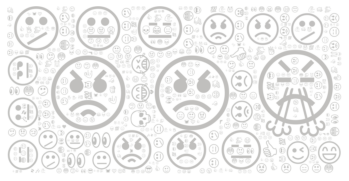

In [474]:
btc=emoji_cloud.generate(emojis['btc'])
btc

#emojis['btc']
#only_uncleaned_dict['btc']['body']

# ETH

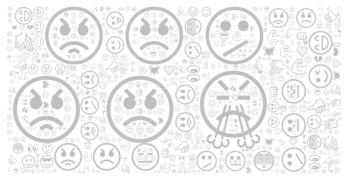

In [475]:
eth=emoji_cloud.generate(emojis['eth'])
eth

# SOL

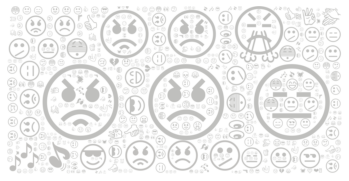

In [476]:
sol=emoji_cloud.generate(emojis['sol'])
sol

# ADA

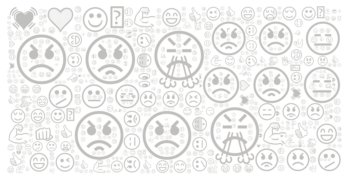

In [477]:
ada=emoji_cloud.generate(emojis['ada'])
ada

# DOT

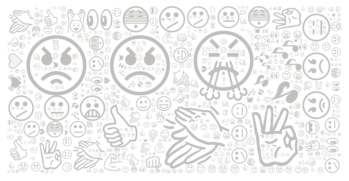

In [478]:
dot=emoji_cloud.generate(emojis['dot'])
dot

# CRO

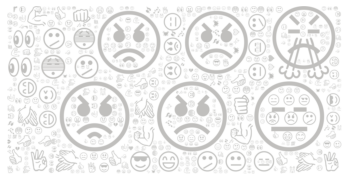

In [480]:
cro=emoji_cloud.generate(emojis['cro'])
cro

# ALGO

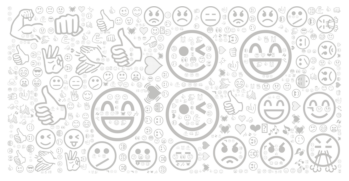

In [481]:
algo=emoji_cloud.generate(emojis['algo'])
algo

# traditional sentiment analysis for each crypto

In [492]:
only_uncleaned_dict

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

analyzer = SentimentIntensityAnalyzer() 


#get sentiment for each crypto using uncleaned data (to pick up on punctuation and capitalization etc)
for key in only_uncleaned_dict:
        print(key, analyzer.polarity_scores(only_uncleaned_dict[key]['body']))

btc {'neg': 0.073, 'neu': 0.806, 'pos': 0.121, 'compound': 1.0}
eth {'neg': 0.069, 'neu': 0.8, 'pos': 0.131, 'compound': 1.0}
sol {'neg': 0.09, 'neu': 0.781, 'pos': 0.129, 'compound': 1.0}
ada {'neg': 0.077, 'neu': 0.783, 'pos': 0.14, 'compound': 1.0}
dot {'neg': 0.05, 'neu': 0.803, 'pos': 0.147, 'compound': 1.0}
matic {'neg': 0.059, 'neu': 0.792, 'pos': 0.148, 'compound': 1.0}
cro {'neg': 0.05, 'neu': 0.801, 'pos': 0.149, 'compound': 1.0}
algo {'neg': 0.05, 'neu': 0.775, 'pos': 0.175, 'compound': 1.0}
